In [1]:
from more_itertools import pairwise
import igraph as ig
import random
import colorsys
from datetime import datetime, timedelta
import pickle
from utils import layout_geo


In [2]:
period = 'april2022'
data_path = f'../../data/{period}/processed'


In [3]:
def to_stop_tuples(tratte_data):
    # Pairwise iteration
    for t1, t2 in pairwise(tratte_data.itertuples(index=False)):
        if t1.route_id == t2.route_id and t2.stop_sequence > t1.stop_sequence:
            departure_time1 = datetime.strptime(
                t1.departure_time, "%H:%M:%S").time()
            departure_time1 = timedelta(
                hours=departure_time1.hour, minutes=departure_time1.minute, seconds=departure_time1.second)
            arrival_time2 = datetime.strptime(
                t2.arrival_time, "%H:%M:%S").time()
            arrival_time2 = timedelta(
                hours=arrival_time2.hour, minutes=arrival_time2.minute, seconds=arrival_time2.second)
            yield (t1.route_id, t1.stop_id, t2.stop_id, (arrival_time2 - departure_time1).seconds)


In [4]:
def rand_color():
    h, s, l = random.random(), 0.5 + random.random()/2.0, 0.4 + random.random()/5.0
    r, g, b = [int(256*i) for i in colorsys.hls_to_rgb(h, l, s)]
    return (r / 255, g / 255, b / 255)


In [5]:
with open(f'{data_path}/trenord.pickle', 'rb') as data:
    calendar, routes, stop_times, stops, trips, tratte, weeks = pickle.load(
        data)


In [6]:
# Tratte data
tratte_tuple = {(route_id, stop_id1, stop_id2)
                for route_id, stop_id1, stop_id2, _ in to_stop_tuples(tratte)}

# Routes data
routes = {route_id for route_id, _, _ in tratte_tuple}
# Routes color
routes_color = {route_id: rand_color() for route_id in routes}


In [7]:
from itertools import groupby
from statistics import mean

keyfunct = key = lambda v: (lambda route_id1, stop_id1, stop_id2, _: (
    route_id1, stop_id1, stop_id2))(*v)
grouped = groupby(sorted(to_stop_tuples(tratte), key=keyfunct), key=keyfunct)
tratta_time = {k: mean(tratta_time for _, _, _, tratta_time in g)
               for k, g in grouped}


In [8]:
g = ig.Graph(directed=True)

g.add_vertices(
    n=stops.stop_id,
    attributes={
        'label': stops.stop_name,
        'lat': stops.stop_lat,
        'lon': stops.stop_lon
    }
)

g.add_edges(
    es=[(stop_id1, stop_id2) for _, stop_id1, stop_id2 in tratte_tuple],
    attributes={
        'label': [route_id for route_id, _, _ in tratte_tuple],
        'color': [routes_color[route_id] for route_id, _, _ in tratte_tuple],
        'time_second': [tratta_time[route_id, stop_id1, stop_id2] for route_id, stop_id1, stop_id2 in tratte_tuple]
    }
)


In [9]:
# Adding num_train
g.es['num_train'] = 0.0
for l1, l2 in pairwise(weeks.itertuples(index=False)):
    if l1.trip_short_name == l2.trip_short_name and l2.stop_sequence > l1.stop_sequence:
        edge = g.es.select(
            _source=g.vs(name=l1.stop_id)[0].index,
            _target=g.vs(name=l2.stop_id)[0].index,
            label=l1.route_id
        )
        if len(edge) == 1:
            edge[0]['num_train'] = edge[0]['num_train'] + \
                (l1.times_in_week / 7.0)


In [10]:
g = g.subgraph_edges(g.es.select(num_train_gt=0, time_second_gt=0))


In [11]:
# Save the graph
save_path = '../../data/graphs/' + period + '.graphml'
g.write_graphml(save_path)


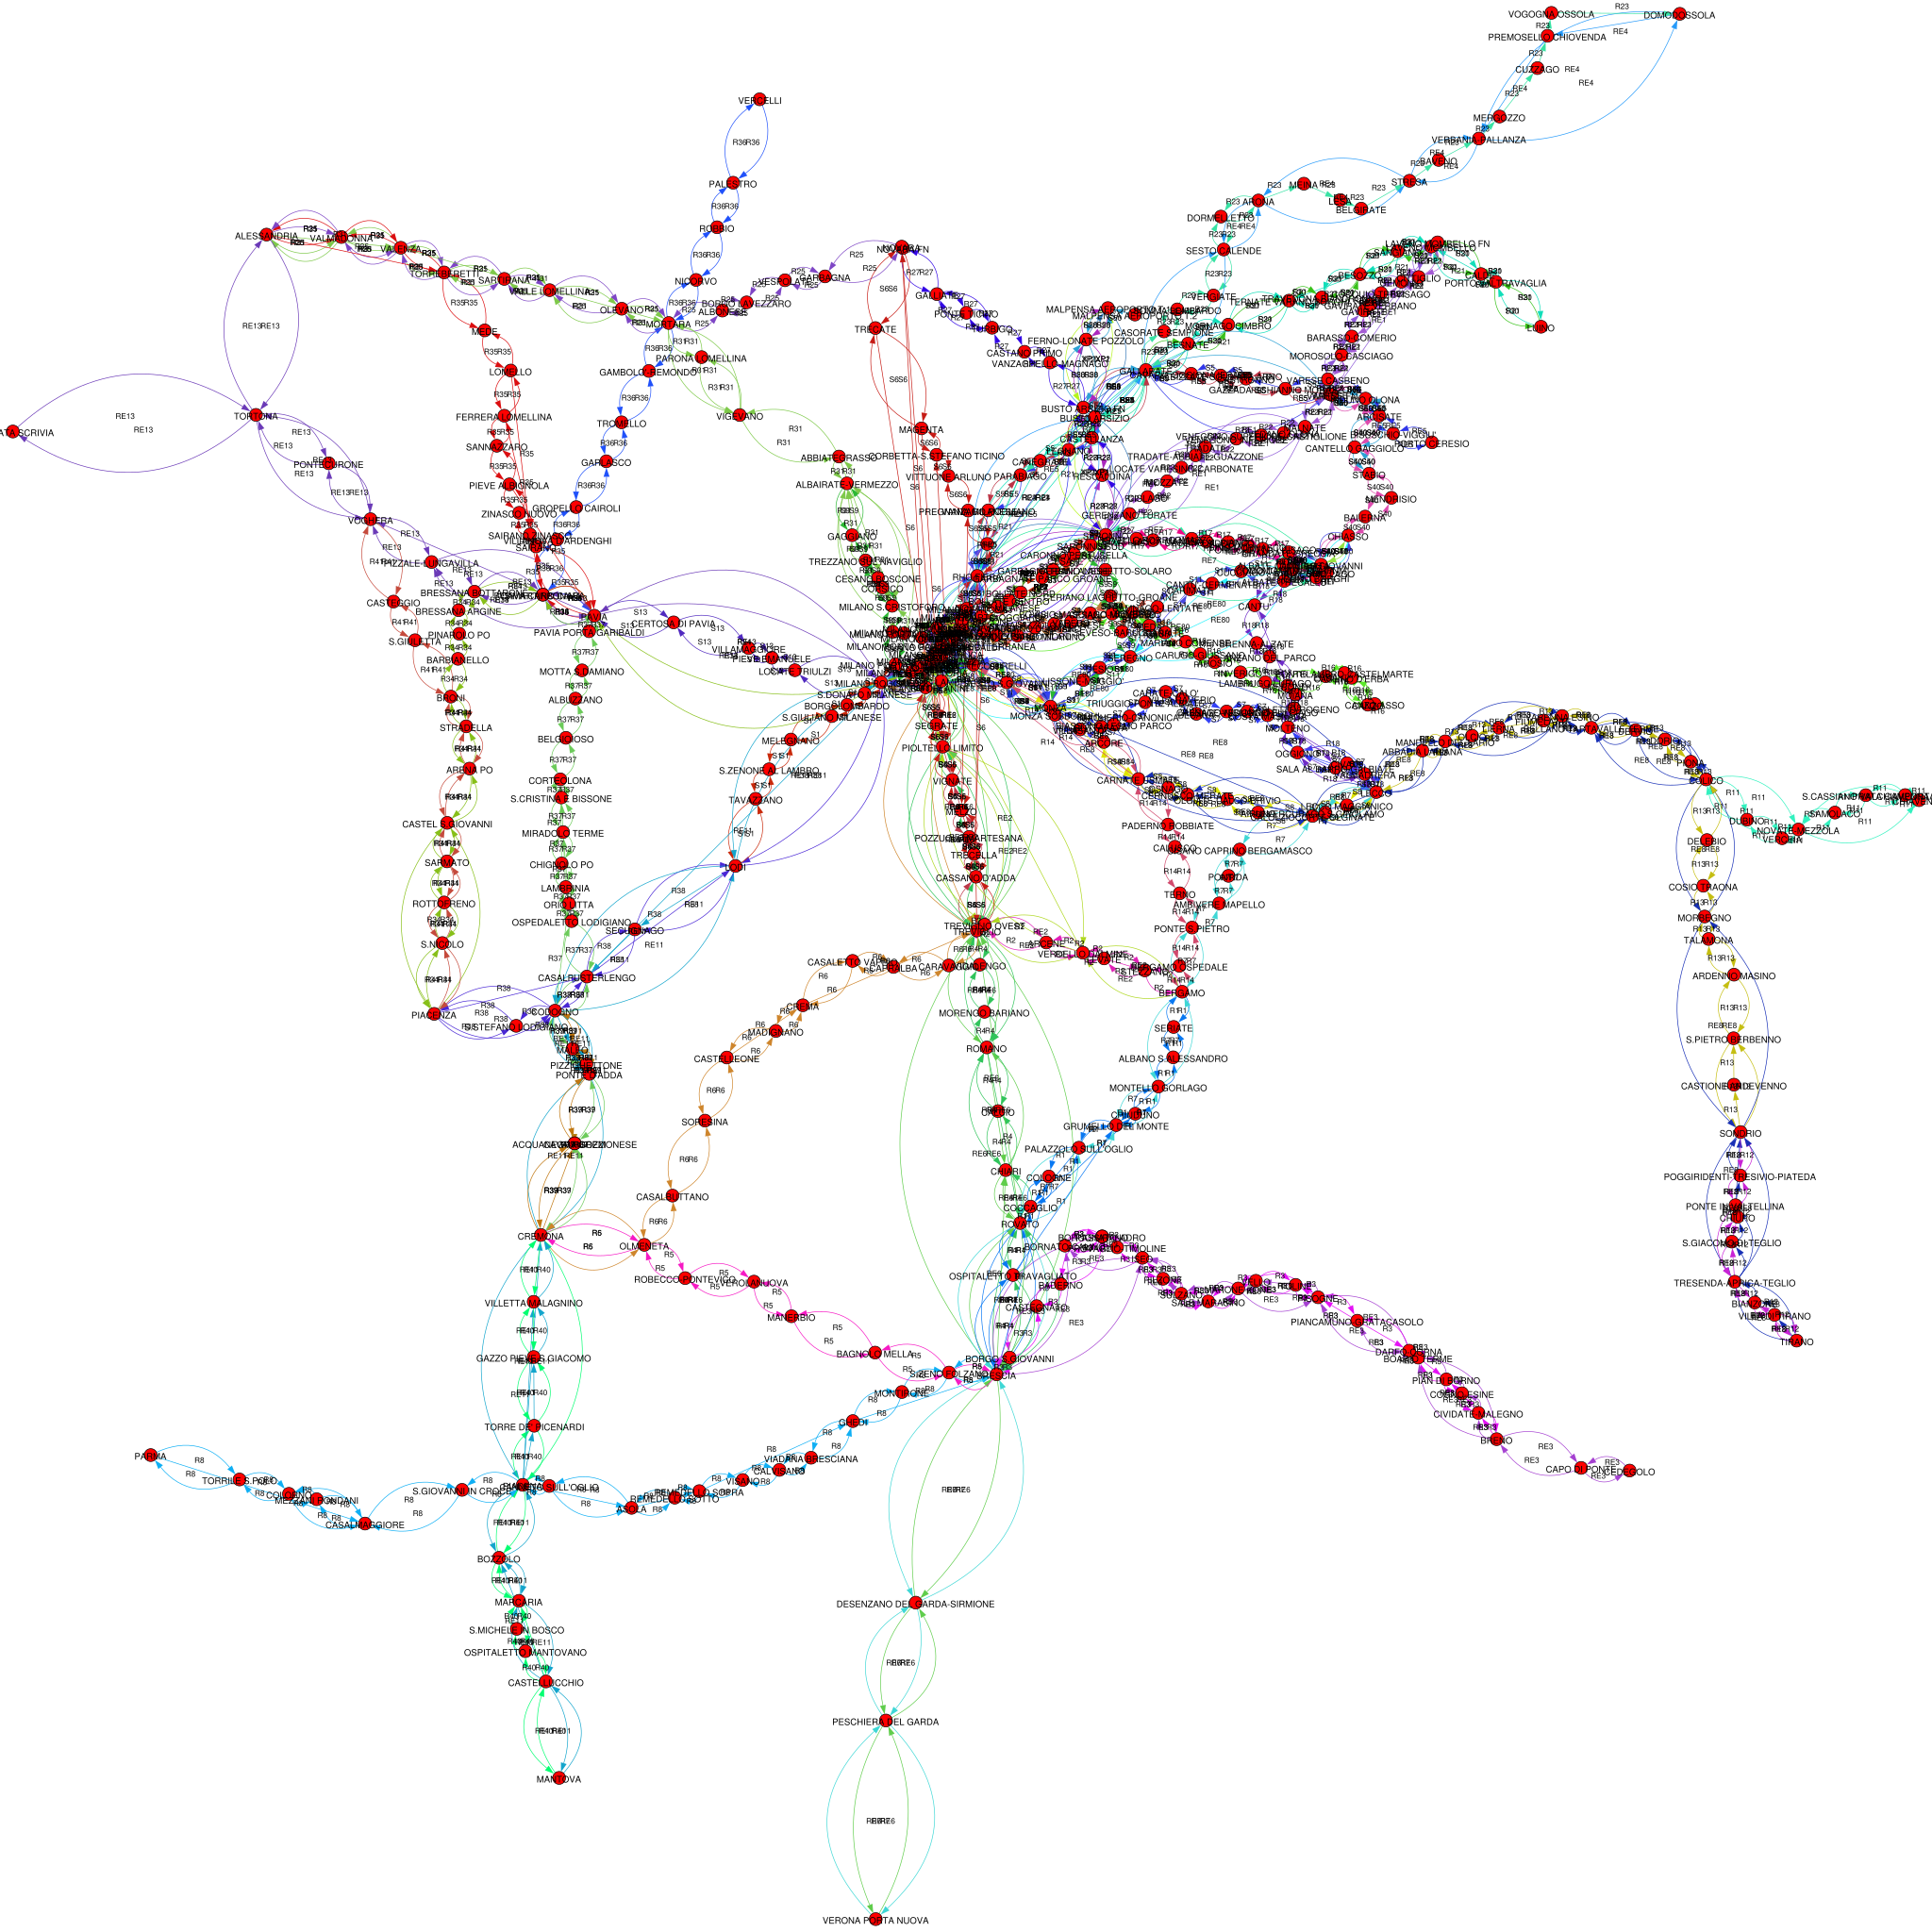

In [12]:
visual_style = {
    "layout": layout_geo(g)
}

ig.plot(g, bbox=(0, 0, 3000, 3000), **visual_style)
